# Introduction to W&B

<!--- @wandbcode{dlai_01} -->

We will add `wandb` to sprite classification model training, so that we can track and visualize important metrics, gain insights into our model's behavior and make informed decisions for model improvements. We will also see how to compare and analyze different experiments, collaborate with team members, and reproduce results effectively.

In [ ]:
import math
from pathlib import Path
from types import SimpleNamespace
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from utilities import get_dataloaders

import wandb

### Sprite classification

We will build a simple model to classify sprites. You can see some examples of sprites and corresponding classes in the image below.

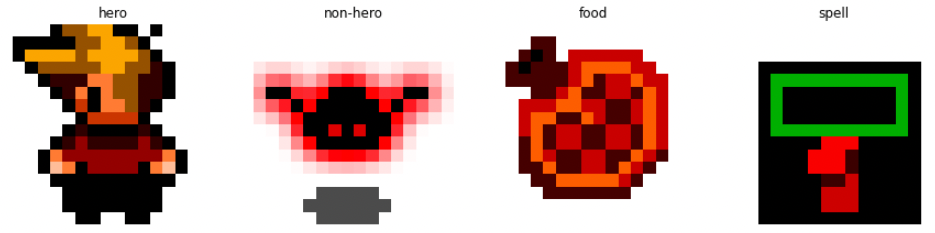
<!-- <img src="sprite_sample.png" alt="Alt Text" width="700"/> -->

In [ ]:
INPUT_SIZE = 3 * 16 * 16
OUTPUT_SIZE = 5
HIDDEN_SIZE = 256
NUM_WORKERS = 2
CLASSES = ["hero", "non-hero", "food", "spell", "side-facing"]
DATA_DIR = Path('./data/')
DEVICE = torch.device("cuda" if torch.cuda.is_available()  else "cpu")

def get_model(dropout):
    "Simple MLP with Dropout"
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(INPUT_SIZE, HIDDEN_SIZE),
        nn.BatchNorm1d(HIDDEN_SIZE),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)
    ).to(DEVICE)

In [ ]:
# Let's define a config object to store our hyperparameters
config = SimpleNamespace(
    epochs = 2,
    batch_size = 128,
    lr = 1e-5,
    dropout = 0.5,
    slice_size = 10_000,
    valid_pct = 0.2,
)

In [ ]:
def train_model(config):
    "Train a model with a given config"
    
    wandb.init(
        project="dlai_intro",
        config=config,
    )

    # Get the data
    train_dl, valid_dl = get_dataloaders(DATA_DIR, 
                                         config.batch_size, 
                                         config.slice_size, 
                                         config.valid_pct)
    n_steps_per_epoch = math.ceil(len(train_dl.dataset) / config.batch_size)

    # A simple MLP model
    model = get_model(config.dropout)

    # Make the loss and optimizer
    loss_func = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=config.lr)

    example_ct = 0

    for epoch in tqdm(range(config.epochs), total=config.epochs):
        model.train()

        for step, (images, labels) in enumerate(train_dl):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            train_loss = loss_func(outputs, labels)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            example_ct += len(images)
            metrics = {
                "train/train_loss": train_loss,
                "train/epoch": epoch + 1,
                "train/example_ct": example_ct
            }
            wandb.log(metrics)
            
        # Compute validation metrics, log images on last epoch
        val_loss, accuracy = validate_model(model, valid_dl, loss_func)
        # Compute train and validation metrics
        val_metrics = {
            "val/val_loss": val_loss,
            "val/val_accuracy": accuracy
        }
        wandb.log(val_metrics)
    
    wandb.finish()


In [ ]:
def validate_model(model, valid_dl, loss_func):
    "Compute the performance of the model on the validation dataset"
    model.eval()
    val_loss = 0.0
    correct = 0

    with torch.inference_mode():
        for i, (images, labels) in enumerate(valid_dl):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            # Forward pass
            outputs = model(images)
            val_loss += loss_func(outputs, labels) * labels.size(0)

            # Compute accuracy and accumulate
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            
    return val_loss / len(valid_dl.dataset), correct / len(valid_dl.dataset)


### W&B account
[Sign up](https://wandb.ai/site) for a free account at https://wandb.ai/site and then login to your wandb account to store the results of your experiments and use advanced W&B features. You can also continue to learn in anonymous mode. If you have an existing W&B account, and your browser automatically logs you in, be sure to use it here to avoid confusion.

In [ ]:
wandb.login(anonymous="allow")

### Train model
Let's train the model with default config and check how it's doing in W&B. 

In [ ]:
train_model(config)

In [ ]:
# So let's change the learning rate to a 1e-3 
# and see how this affects our results.
config.lr = 1e-4
train_model(config)

In [ ]:
config.lr = 1e-4
train_model(config)

In [ ]:
config.dropout = 0.1
config.epochs = 1
train_model(config)

In [ ]:
config.lr = 1e-3
train_model(config)